# 13C-MFA Constrained Flux Balance Analysis (08302023 data + StrainDesign) 
The purpose of the notebook is to run flux balance analysis to find the set of genome scale fluxes that maximizes biomass production.<br><br>
The flux balance analysis results are then compared to reaction rates determined by 13C-metabolic flux analysis (13C-MFA). <br><br>
The results of this notebook will be compared to transcript constained genome scale model flux results via E-Flux2. <br><br>
This notebook looks at glucose, glycerol, acetate, and oleic acid as sole carbon sources. <br><br>
In all cases, parsimonious flux balance analysis (pFBA) was used to prevent degenerate solutions.


### Load imports

In [1]:
import cobra
import straindesign as sd
import pandas as pd
import sys


source_dir = '../src'
sys.path.append(source_dir)
from add_flux_column_to_13c_flux_df import add_flux_column_to_13c_flux_df
from add_fva_columns_to_13c_flux_df import add_fva_columns_to_13c_flux_df
from flux_prediction_scatterplot import flux_prediction_scatterplot
from make_rxn_constraint_string import make_rxn_constraint_string

### Load the genome scale model

In [3]:
model = cobra.io.json.load_json_model('../genome_scale_models/iYLI647_corr_3.json')

### Rename some reactions to remove parentheses
This is because parentheses in reaction ids cause problems with StrainDesign

In [4]:
model.reactions.get_by_id('EX_glc(e)').id = 'EX_glc_e'
model.reactions.get_by_id('EX_glyc(e)').id = 'EX_glyc_e'
model.reactions.get_by_id('EX_ocdcea(e)').id = 'EX_ocdcea_e'
model.reactions.get_by_id('EX_h2o(e)').id = 'EX_h2o_e'
model.reactions.get_by_id('EX_h(e)').id = 'EX_h_e'
model.reactions.get_by_id('EX_nh4(e)').id = 'EX_nh4_e'
model.reactions.get_by_id('EX_o2(e)').id = 'EX_o2_e'
model.reactions.get_by_id('EX_pi(e)').id = 'EX_pi_e'
model.reactions.get_by_id('EX_so4(e)').id = 'EX_so4_e'

# print an example reaction
model.reactions.get_by_id('EX_glc_e')

Reaction identifier,EX_glc_e
Name,D Glucose exchange
Memory address,0x15c0bbac0
Stoichiometry,glc_D[e] <=> D_Glucose <=>
GPR,YALI0D01111g or YALI0D18876g or YALI0D00132g or YALI0B01342g or YALI0E23287g or YALI0B00396g or...
Lower bound,-10.0
Upper bound,1000.0


### Load 13C-MFA data

In [5]:
central_rxn_df = pd.read_excel('../data/13c_mfa/INCA_model_10232023_GR.xlsx', sheet_name='flux_data')

# calculate the number of reactions in the 13C MFA that are mapped to the GSM
mapped_rxn_df = central_rxn_df.dropna(subset = ["reaction_ids"])

print(f'There are {len(mapped_rxn_df)} reactions in the 13C MFA that are mapped to the GSM')

central_rxn_df.head(49)

There are 43 reactions in the 13C MFA that are mapped to the GSM


,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,glycerol_flux,glycerol_std_err,glycerol_LB,glycerol_UB,glycerol_ΔB,oleic_acid_flux,oleic_acid_std_err,oleic_acid_LB,oleic_acid_UB,oleic_acid_ΔB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,1.000000e+02,5590.0000,100.0000,100.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,100.000000,5.974500e-11,100.0000,100.0000,0.0000,NaN,NaN,NaN,NaN,NaN
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,100.000000,5.974500e-11,100.0000,100.0000,0.0000,NaN,NaN,NaN,NaN,NaN
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.000000e+02,2.594100e-10,100.0000,100.0000,0.0000
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,1.615850e+01,903.3512,7.6380,25.0760,...,-19.168800,1.740200e+00,-26.9472,-15.8469,11.1003,-1.035480e+02,3.191300e+00,-345.1830,-82.7140,262.4690
5,glycolysis/gluconeogensis,R5 net,F6P + ATP <-> FBP,PFK or reverse_FBP,emp,cytosol,5.470010e+01,3057.7000,50.9378,57.0545,...,-16.913700,6.263000e-01,-19.3382,-15.6909,3.6473,-9.801660e+01,3.020800e+00,-167.8457,-86.4527,81.3930
6,glycolysis/gluconeogensis,R6 net,FBP <-> DHAP + GAP,FBA,emp,cytosol,5.470010e+01,3057.7000,50.9378,57.0545,...,-16.913700,6.263000e-01,-19.3382,-15.6909,3.6473,-9.801660e+01,3.020800e+00,-167.8457,-86.4527,81.3930
7,glycolysis/gluconeogensis,R7 net,DHAP <-> GAP,TPI,emp,cytosol,5.295380e+01,2960.1000,49.0946,55.3190,...,82.027300,6.319000e-01,78.9156,83.2640,4.3484,-1.083464e+02,3.339200e+00,-176.4324,-95.9590,80.4734
8,glycolysis/gluconeogensis,R8 net,GAP <-> G3P + ATP + NADH,GAPD,emp,cytosol,1.262018e+02,7054.7000,120.5904,130.0255,...,65.802800,7.356000e-01,63.6523,67.2932,3.6409,-2.051634e+02,6.323000e+00,-256.9114,-184.8529,72.0585
9,glycolysis/gluconeogensis,R9 net,G3P <-> PEP,ENO,emp,cytosol,1.214871e+02,6791.1000,115.6079,125.6591,...,63.201900,7.767000e-01,61.1082,64.7828,3.6746,-2.169470e+02,7.763400e+00,-262.8657,-194.3019,68.5638


### Develop Flux Map Generator Function

FileNotFoundError: [Errno 2] No such file or directory: './images/unlabeled_flux_map.png'

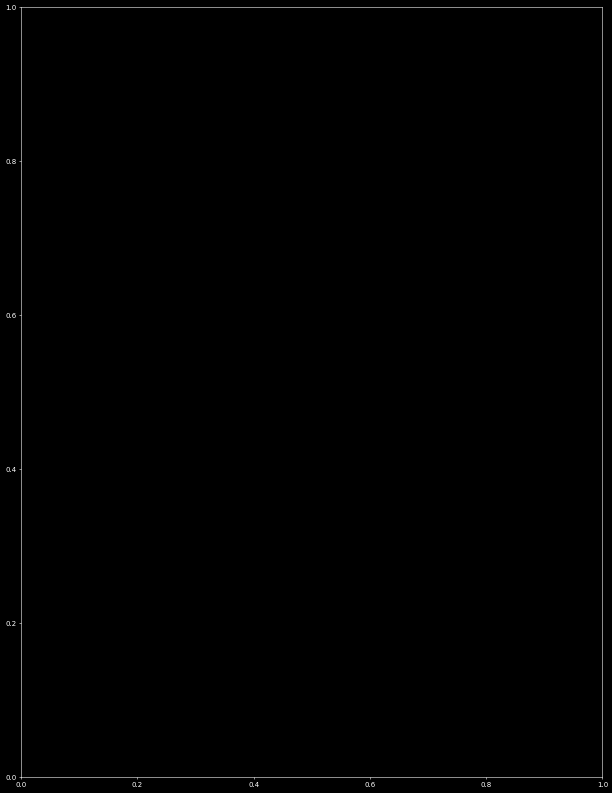

In [6]:
from matplotlib import pyplot as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox, TextArea)

# This function takes in a flux data frame and column name, and generates a flux map using the flux values in the specified column
def generate_flux_map(
    flux_df=None, 
    glucose_column_name='', 
    glycerol_column_name='', 
    oleic_acid_column_name='', 
    file_name='',
):
    # define plot area
    fig, ax = plt.subplots(figsize=(15, 20), dpi=50)
    
    # load unlabeled image and set as plot background
    unlabeled_image = plt.imread('./images/unlabeled_flux_map.png')
    imagebox = OffsetImage(unlabeled_image)
    imagebox.image.axes = ax
    xy = (0.5, 0.5)
    ab = AnnotationBbox(imagebox, xy, frameon=False)
    ax.add_artist(ab)

    # loop over each reaction in the dataframe
    for _, row in flux_df.iterrows():
        # check that there is a location for the reaction's flux
        if not pd.isnull(row['Location on map']):
            # get the flux value
            flux_value = row[column_name]

            # get the location of the reaction's flux on the map as a tuple
            location =  row['Location on map'].replace('(', '').replace(')', '')
            location_list = location.split(',')
            location_tuple = tuple((int(location_list[0]), int(location_list[1])))

            # create a text area with the flux value
            offsetbox = TextArea(
                f'{flux_value:.1f}', 
                textprops=dict(fontsize=22, color='black')
            )
            
            # creates an annotation box, which is a box that can be placed on the plot area.
            ab = AnnotationBbox(
                offsetbox, 
                xy,
                xybox=location_tuple,
                xycoords='data',
                boxcoords="offset points",
                frameon=False
            )

            # add the annotation box to the plot area
            ax.add_artist(ab)

    # ensure that the axes have minimal styles 
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    
    # save and show the plot
    plt.savefig(file_name)
    plt.show()

generate_flux_map(
    flux_df=None, 
    glucose_column_name='glucose_flux', 
    glycerol_column_name='glycerol_flux',
    oleic_acid_column_name='oleic_acid_flux',
    file_name='../figures/test_flux_map.png',
)

# Glucose

### Define a function to build constraint strings from 13C-MFA data

In [7]:
def build_13c_constraint_string(central_rxn_df, lower_bound_row, upper_bound_row):
    
    # key node reactions to constrain
    key_pathway_reactions = {
        'EMP': 'GAPD',
        'TCA': 'CSm',
        'PPP': 'GND',
    }
    
    constraint_strings = []

    for pathway, reaction_ids in key_pathway_reactions.items():
        row = central_rxn_df.loc[central_rxn_df['reaction_ids'] == reaction_ids]
        # get the lower bound for this reaction
        lower_bound = row[lower_bound_row]
        upper_bound = row[upper_bound_row]

        constraint_string = make_rxn_constraint_string(reaction_ids, lower_bound, upper_bound)
        # print(constraint_string)
        # print(pathway, reaction)
        constraint_strings.append(constraint_string)

    full_constraint_string = ', '.join(constraint_strings)
    return full_constraint_string

    

build_13c_constraint_string(central_rxn_df, 'glucose_LB', 'glucose_UB')


'GAPD >= 8    120.5904\nName: glucose_LB, dtype: float64, GAPD <= 8    130.0255\nName: glucose_UB, dtype: float64, CSm >= 22    28.17\nName: glucose_LB, dtype: float64, CSm <= 22    51.2108\nName: glucose_UB, dtype: float64, GND >= 13    50.2982\nName: glucose_LB, dtype: float64, GND <= 13    69.3906\nName: glucose_UB, dtype: float64'

### Build glucose constraint string from 13C-MFA data

In [9]:
# update the media to minimal medium with glucose as the sole carbon source
medium = model.medium
medium['EX_glc_e'] = 100
medium['EX_glyc_e'] = 0
medium['EX_ocdcea_e'] = 0
medium['EX_h2o_e'] = 10000
medium['EX_h_e'] = 10000
medium['EX_nh4_e'] = 10000
medium['EX_o2_e'] = 10000
medium['EX_pi_e'] = 10000
medium['EX_so4_e'] = 10000
medium['trehalose_c_tp'] = 0
model.medium = medium

# print the medium composition
[print(model.medium[m], m) for m in model.medium]

lower_bound_row = 'glucose_LB'
upper_bound_row = 'glucose_UB'

constraint_strings = []

# loop over rows in the central flux dataframe
for _, row in central_rxn_df.iterrows():  
    # get the GSM reaction mapping for this reaction
    reaction_ids = row['reaction_ids']
    pathway = row['pathway']

    # get the lower bound for this reaction
    lower_bound = row[lower_bound_row]
    upper_bound = row[upper_bound_row]

    # determine if reaction should be included in the constraint string
    reaction_ids_not_nan = not pd.isna(reaction_ids)
    pathway_not_transport = pathway != 'transport'
    bounds_are_not_nan = not pd.isna(lower_bound) and not pd.isna(upper_bound)
    

    if reaction_ids_not_nan and pathway_not_transport and bounds_are_not_nan:
        print(f'13C-MFA bounds: {lower_bound} - {upper_bound}')

        # make the constraint string
        constraint_string = make_rxn_constraint_string(reaction_ids, lower_bound, upper_bound)

        glucose_fba_solution = sd.fba(model, constraints=constraint_string, obj='biomass_glucose', obj_sense='maximize', pfba=1)

        # add the constraint string to the list
        constraint_strings.append(constraint_string)
        print(constraint_string)
        print(f"max biomass flux: {glucose_fba_solution['biomass_glucose']}")
        print()



full_constraint_string = ', '.join(constraint_strings)
print(len(full_constraint_string))
full_constraint_string 

100 EX_glc_e
10000 EX_h2o_e
10000 EX_h_e
10000 EX_nh4_e
10000 EX_o2_e
10000 EX_pi_e
10000 EX_so4_e
13C-MFA bounds: 100.0 - 100.0
EX_glc_e >= -100.0, EX_glc_e <= -100.0
max biomass flux: 10.016082967112

13C-MFA bounds: 7.638 - 25.076
PGI >= 7.638, PGI <= 25.076
max biomass flux: 10.016082967112

13C-MFA bounds: 50.9378 - 57.0545
PFK - FBP >= 50.9378, PFK - FBP <= 57.0545
max biomass flux: 10.01608296711

13C-MFA bounds: 50.9378 - 57.0545
FBA >= 50.9378, FBA <= 57.0545
max biomass flux: 10.016082967112

13C-MFA bounds: 49.0946 - 55.319
TPI >= 49.0946, TPI <= 55.319
max biomass flux: 10.016082967112

13C-MFA bounds: 120.5904 - 130.0255
GAPD >= 120.5904, GAPD <= 130.0255
max biomass flux: 10.01608296711

13C-MFA bounds: 115.6079 - 125.6591
ENO >= 115.6079, ENO <= 125.6591
max biomass flux: 10.016082967111

13C-MFA bounds: 111.0774 - 126.5098
PYK >= 111.0774, PYK <= 126.5098
max biomass flux: 10.016082967112

13C-MFA bounds: 0.0 - 9.6176
PPCK >= 0.0, PPCK <= 9.6176
max biomass flux: 10.016

'EX_glc_e >= -100.0, EX_glc_e <= -100.0, PGI >= 7.638, PGI <= 25.076, PFK - FBP >= 50.9378, PFK - FBP <= 57.0545, FBA >= 50.9378, FBA <= 57.0545, TPI >= 49.0946, TPI <= 55.319, GAPD >= 120.5904, GAPD <= 130.0255, ENO >= 115.6079, ENO <= 125.6591, PYK >= 111.0774, PYK <= 126.5098, PPCK >= 0.0, PPCK <= 9.6176, G6PDH2 >= 50.2982, G6PDH2 <= 69.3906, GND >= 50.2982, GND <= 69.3906, RPI >= -25.2153, RPI <= -19.008, RPE >= 31.2322, RPE <= 42.9235, TKT1 + TKT2 >= 31.2322, TKT1 + TKT2 <= 42.9235, TKT2 >= 14.4968, TKT2 <= 21.0188, TKT1 >= 16.7898, TKT1 <= 23.1501, TALA >= 16.7898, TALA <= 23.1501, TALA >= 16.7898, TALA <= 23.1501, PDHm >= 86.6629, PDHm <= 100.6986, CSm >= 28.17, CSm <= 51.2108, ACONTm >= 12.6008, ACONTm <= 40.3555, ICDHxm >= 0.0, ICDHxm <= 40.3559, ICDHym >= 0.0, ICDHym <= 30.8352, AKGDam >= 0.0, AKGDam <= 29.3331, AKGDbm >= 0.0, AKGDbm <= 29.3331, SUCD2_u6m >= 15.0997, SUCD2_u6m <= 40.2079, SUCD1m >= 15.0997, SUCD1m <= 40.2079, FUMm >= 17.1305, FUMm <= 41.8427, MDHm >= 28.17, M

### Calculate glucose GSM pFBA solution

In [ ]:
# update the media to minimal medium with glucose as the sole carbon source
medium = model.medium
medium['EX_glc_e'] = 100
medium['EX_glyc_e'] = 0
medium['EX_ocdcea_e'] = 0
medium['EX_h2o_e'] = 10000
medium['EX_h_e'] = 10000
medium['EX_nh4_e'] = 10000
medium['EX_o2_e'] = 10000
medium['EX_pi_e'] = 10000
medium['EX_so4_e'] = 10000
medium['trehalose_c_tp'] = 0
model.medium = medium

# print the medium composition
[print(model.medium[m], m) for m in model.medium]

temp_constraint_string = 'EX_glc_e >= -100.0, EX_glc_e <= -100.0, PGI >= 7.638, PGI <= 25.076, PFK - FBP >= 50.9378'
glucose_fba_solution = sd.fba(model, constraints=full_constraint_string, obj='biomass_glucose', obj_sense='maximize', pfba=1)

print()

max_glucose_biomass_flux = glucose_fba_solution['biomass_glucose']
PGI_flux = glucose_fba_solution['PGI']
print(f'Maximum biomass flux: {max_glucose_biomass_flux}.')
print(f'PGI flux: {PGI_flux}.')
print(f'The number of active reactions in pFBA: {sum([abs(flux) > 0.1 for flux in glucose_fba_solution.fluxes.values()])}')

# make a list of dictionaries with the reaction id, name, flux, and absolute flux
reactions = []
for reaction_id, flux in glucose_fba_solution.fluxes.items():

  reactions.append({
    'reaction_id': reaction_id,
    'reaction_name': model.reactions.get_by_id(reaction_id).name,
    'full_reaction': model.reactions.get_by_id(reaction_id).reaction,
    'flux': flux,
    'absolute_flux': abs(flux), # use for sorting, then drop
  })

# make a dataframe from the list of dictionaries
glucose_gsm_fba_df = pd.DataFrame(reactions)

# sort the dataframe by absolute flux
glucose_gsm_fba_df = glucose_gsm_fba_df.sort_values(by=['absolute_flux'], ascending=False)

# drop the absolute flux column
glucose_gsm_fba_df = glucose_gsm_fba_df.drop(columns=['absolute_flux'])

glucose_gsm_fba_df.head()

### Calculate glucose GSM pFBA FVA 

In [ ]:
# run FVA for 90% of biomass production on the GSM
biomass_fraction = 0.9
glucose_fva_solution = sd.fva(
  model, 
  constraints=f'EX_glc_e = -100.000, biomass_C >= {biomass_fraction * max_glucose_biomass_flux}',
)

# define a function to determine if a reaction is active
def is_active(row):
  return abs(row.maximum) > 0.1 or abs(row.minimum) > 0.1

print(f'The number of active reactions in FVA: {sum([is_active(row) for _, row in glucose_fva_solution.iterrows()])}')

# make a list of dictionaries with the reaction id, name, flux, and absolute flux
fva_upper_bounds = []
fva_lower_bounds = []

# loop over the reactions in the GSM
for _, row in glucose_gsm_fba_df.iterrows():
  reaction_id = row.reaction_id

  # get the upper and lower bounds from the FVA solution
  upper_bound = glucose_fva_solution.loc[reaction_id, 'maximum']
  lower_bound = glucose_fva_solution.loc[reaction_id, 'minimum']

  fva_upper_bounds.append(upper_bound)
  fva_lower_bounds.append(lower_bound)

# add the upper and lower bounds to the dataframe
glucose_gsm_fba_df['fva_upper_bound'] = fva_upper_bounds
glucose_gsm_fba_df['fva_lower_bound'] = fva_lower_bounds

# save the dataframe to a csv file
glucose_gsm_fba_df.to_csv('../results/gsm_fluxes/glucose_gsm_13C_fba.csv', index=False)

# display updated dataframe
glucose_gsm_fba_df


### Add glucose pFBA columns to 13C-MFA data

In [ ]:
# add the GSM flux predictions to the 13C-MFA dataframe
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, glucose_gsm_fba_df, 'glucose_pFBA_flux')

# add the GSM flux predictions to the 13C-MFA dataframe
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, glucose_gsm_fba_df, f'glucose_pFBA_{100*biomass_fraction}%')

central_rxn_df.head()

# Glycerol

### Calculate glycerol GSM pFBA solution

In [ ]:
# update the media to minimal medium with glycerol as the sole carbon source
medium = model.medium
medium['EX_glc_e'] = 0
medium['EX_glyc_e'] = 100
medium['EX_ocdcea_e'] = 0
medium['EX_h2o_e'] = 10000
medium['EX_h_e'] = 10000
medium['EX_nh4_e'] = 10000
medium['EX_o2_e'] = 10000
medium['EX_pi_e'] = 10000
medium['EX_so4_e'] = 10000
medium['trehalose_c_tp'] = 0
model.medium = medium

# print the medium composition
[print(model.medium[m], m) for m in model.medium]

# run biomass-maximizing pFBA
glycerol_fba_solution = sd.fba(model, constraints='EX_glyc_e = -100.000', obj='biomass_C', obj_sense='maximize', pfba=1)

max_glycerol_biomass_flux = glycerol_fba_solution['biomass_C']
print(f'Maximum biomass flux: {max_glycerol_biomass_flux}.')
print(f'The number of active reactions in pFBA: {sum([abs(flux) > 0.1 for flux in glycerol_fba_solution.fluxes.values()])}')

# make a list of dictionaries with the reaction id, name, flux, and absolute flux
reactions = []
for reaction_id, flux in glycerol_fba_solution.fluxes.items():

  reactions.append({
    'reaction_id': reaction_id,
    'reaction_name': model.reactions.get_by_id(reaction_id).name,
    'full_reaction': model.reactions.get_by_id(reaction_id).reaction,
    'flux': flux,
    'absolute_flux': abs(flux), # use for sorting, then drop
  })

# make a dataframe from the list of dictionaries
glycerol_gsm_fba_df = pd.DataFrame(reactions)

# sort the dataframe by absolute flux
glycerol_gsm_fba_df = glycerol_gsm_fba_df.sort_values(by=['absolute_flux'], ascending=False)

# drop the absolute flux column
glycerol_gsm_fba_df = glycerol_gsm_fba_df.drop(columns=['absolute_flux'])

glycerol_gsm_fba_df.head()

### Calculate glycerol GSM pFBA FVA 

In [ ]:
# run FVA for 90% of biomass production on the GSM
biomass_fraction = 0.9
glycerol_fva_solution = sd.fva(
  model, 
  constraints=f'EX_glyc_e = -100.000, biomass_C >= {biomass_fraction * max_glycerol_biomass_flux}',
)

# define a function to determine if a reaction is active
def is_active(row):
  return abs(row.maximum) > 0.1 or abs(row.minimum) > 0.1

print(f'The number of active reactions in FVA: {sum([is_active(row) for _, row in glycerol_fva_solution.iterrows()])}')

# make a list of dictionaries with the reaction id, name, flux, and absolute flux
fva_upper_bounds = []
fva_lower_bounds = []

# loop over the reactions in the GSM
for _, row in glycerol_gsm_fba_df.iterrows():
  reaction_id = row.reaction_id

  # get the upper and lower bounds from the FVA solution
  upper_bound = glycerol_fva_solution.loc[reaction_id, 'maximum']
  lower_bound = glycerol_fva_solution.loc[reaction_id, 'minimum']

  fva_upper_bounds.append(upper_bound)
  fva_lower_bounds.append(lower_bound)

# add the upper and lower bounds to the dataframe
glycerol_gsm_fba_df['fva_upper_bound'] = fva_upper_bounds
glycerol_gsm_fba_df['fva_lower_bound'] = fva_lower_bounds

# save the dataframe to a csv file
glycerol_gsm_fba_df.to_csv('../results/gsm_fluxes/glycerol_gsm_13C_fba.csv', index=False)

# display updated dataframe
glycerol_gsm_fba_df

### Add glycerol pFBA columns to 13C-MFA data

In [ ]:
# add the GSM flux predictions to the 13C-MFA dataframe
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, glycerol_gsm_fba_df, 'glycerol_pFBA_flux')

# add the GSM flux predictions to the 13C-MFA dataframe
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, glycerol_gsm_fba_df, f'glycerol_pFBA_{100*biomass_fraction}%')

central_rxn_df.head()

# Oleic Acid

### Calculate oleic acid GSM pFBA solution

In [ ]:
# update the media to minimal medium with oleic_acid as the sole carbon source
medium = model.medium
medium['EX_glc_e'] = 0
medium['EX_glyc_e'] = 0
medium['EX_ocdcea_e'] = 10 # this prevents overflow
medium['EX_h2o_e'] = 10000
medium['EX_h_e'] = 10000
medium['EX_nh4_e'] = 10000
medium['EX_o2_e'] = 10000
medium['EX_pi_e'] = 10000
medium['EX_so4_e'] = 10000
medium['trehalose_c_tp'] = 0
model.medium = medium

# print the medium composition
[print(model.medium[m], m) for m in model.medium]

# run biomass-maximizing pFBA
oleic_acid_fba_solution = sd.fba(model, constraints='EX_ocdcea_e = -10.000', obj='biomass_C', obj_sense='maximize', pfba=1)

max_oleic_acid_biomass_flux = oleic_acid_fba_solution['biomass_C']
print(f'Maximum biomass flux: {10 * max_oleic_acid_biomass_flux}.') # restore 100 input flux
print(f'The number of active reactions in pFBA: {sum([abs(flux) > 0.1 for flux in oleic_acid_fba_solution.fluxes.values()])}')

# make a list of dictionaries with the reaction id, name, flux, and absolute flux
reactions = []
for reaction_id, flux in oleic_acid_fba_solution.fluxes.items():

  reactions.append({
    'reaction_id': reaction_id,
    'reaction_name': model.reactions.get_by_id(reaction_id).name,
    'full_reaction': model.reactions.get_by_id(reaction_id).reaction,
    'flux': 10 * flux, # restore 100 input flux
    'absolute_flux': abs(flux), # use for sorting, then drop
  })

# make a dataframe from the list of dictionaries
oleic_acid_gsm_fba_df = pd.DataFrame(reactions)

# sort the dataframe by absolute flux
oleic_acid_gsm_fba_df = oleic_acid_gsm_fba_df.sort_values(by=['absolute_flux'], ascending=False)

# drop the absolute flux column
oleic_acid_gsm_fba_df = oleic_acid_gsm_fba_df.drop(columns=['absolute_flux'])

oleic_acid_gsm_fba_df.head()

### Calculate oleic acid GSM pFBA FVA 

In [ ]:
# run FVA for 90% of biomass production on the GSM
biomass_fraction = 0.9
oleic_acid_fva_solution = sd.fva(
  model, 
  constraints=f'EX_ocdcea_e = -10.000, biomass_C >= {biomass_fraction * max_oleic_acid_biomass_flux}',
)

# define a function to determine if a reaction is active
def is_active(row):
  return abs(row.maximum) > 0.1 or abs(row.minimum) > 0.1

print(f'The number of active reactions in FVA: {sum([is_active(row) for _, row in oleic_acid_fva_solution.iterrows()])}')

# make a list of dictionaries with the reaction id, name, flux, and absolute flux
fva_upper_bounds = []
fva_lower_bounds = []

# loop over the reactions in the GSM
for _, row in oleic_acid_gsm_fba_df.iterrows():
  reaction_id = row.reaction_id

  # get the upper and lower bounds from the FVA solution
  upper_bound = 10 * oleic_acid_fva_solution.loc[reaction_id, 'maximum'] # restore 100 input flux
  lower_bound = 10 * oleic_acid_fva_solution.loc[reaction_id, 'minimum'] # restore 100 input flux

  fva_upper_bounds.append(upper_bound)
  fva_lower_bounds.append(lower_bound)

# add the upper and lower bounds to the dataframe
oleic_acid_gsm_fba_df['fva_upper_bound'] = fva_upper_bounds
oleic_acid_gsm_fba_df['fva_lower_bound'] = fva_lower_bounds

# save the dataframe to a csv file
oleic_acid_gsm_fba_df.to_csv('../results/gsm_fluxes/oleic_acid_gsm_13C_fba.csv', index=False)

# display updated dataframe
oleic_acid_gsm_fba_df


### Add oleic acid pFBA columns to 13C-MFA data

In [ ]:
# add the GSM flux predictions to the 13C-MFA dataframe
central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, oleic_acid_gsm_fba_df, 'oleic_acid_pFBA_flux')

# add the GSM flux predictions to the 13C-MFA dataframe
central_rxn_df = add_fva_columns_to_13c_flux_df(central_rxn_df, oleic_acid_gsm_fba_df, f'oleic_acid_pFBA_{100*biomass_fraction}%')

central_rxn_df.head()

# Save Data

### Save central flux data with pFBA data added

In [ ]:
# save the dataframe to a csv file
central_rxn_df.to_csv('../results/central_fluxes/13C_pfba.csv', index=False, encoding='utf-8-sig')